In [1]:
import tools
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import base
import anz
import tools
import pandas as pd
import data_config
import viz
from scipy.signal import savgol_filter

from pathlib import Path
path = Path(os.getcwd())
project_path = path.parent.absolute()
figure_path = os.path.join(project_path, '_FIGURES')

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 16})

In [2]:
mice_dict = data_config.pilot.mice_dict
scheme = data_config.pilot.scheme
paw_location_markers = data_config.pilot.BPS_TRACK_LOCATION

In [3]:
from collections import defaultdict
dd = defaultdict(list)
for mouse, (dates, epochs) in mice_dict.items():
    data = []
    for date in dates:
        analyzed_dir = os.path.join(r'C:\Users\Peter\Desktop\ANALYZED', mouse, date)
        csv = os.path.join(analyzed_dir, 'notes.csv')
        df = pd.read_csv(csv)
        mask = df['mask'].to_numpy() > 0

        label_regions_per_video, label_names = anz._get_labels(
            os.path.join(analyzed_dir, 'LABELS'))

        bps_to_include = np.unique([x for y in scheme for x in y])
        bp_dict = {bp: i for i, bp in enumerate(bps_to_include)}
        marker_xys_per_video = anz._get_markers(
            os.path.join(analyzed_dir, 'POSE_2D'),
            bps_to_include,
            base.CAMERA_NAMES)

        # grab locations
        x_grab_offset = 5
        y_grab_offset = 0
        grab_bps_ix = [bp_dict[bp] for bp in paw_location_markers]
        grabs = []
        for marker_xys, label_regions in zip(marker_xys_per_video,
                                             label_regions_per_video):
            grabs_per_trial = []
            for r in label_regions['grab']:
                scores = marker_xys[1][grab_bps_ix, :, 2]
                xp = marker_xys[0][grab_bps_ix, :, 0] + x_grab_offset
                yp = marker_xys[1][grab_bps_ix, :, 0] + y_grab_offset
                grab_x = anz._get_grab_locations_atomic(xp, scores, r)
                grab_y = anz._get_grab_locations_atomic(yp, scores, r)
                grabs_per_trial.append([grab_x, grab_y])
            grabs.append(grabs_per_trial)

        pellet_ix = bp_dict['pellet']
        xs = [marker_xys[0][pellet_ix, :, 0] for marker_xys in marker_xys_per_video]
        ys = [marker_xys[1][pellet_ix, :, 0] for marker_xys in marker_xys_per_video]
        ss = [marker_xys[0][pellet_ix, :, 2] for marker_xys in marker_xys_per_video]
        pellet_x = anz.get_pellet_location(xs, ss, plot=False)
        pellet_y = anz.get_pellet_location(ys, ss, plot=False)

        x_errs = []
        grabs_x = [[x[0] for x in gs] for gs in grabs]
        for m, grabs, pellet in zip(mask, grabs_x, pellet_x):
            err = [grab - pellet if m else np.nan for grab in grabs]
            x_errs.append(err)
        data.append(x_errs)

    s = np.nan
    for i, epoch in enumerate(epochs):
        epoch_data = []
        start_ix = dates.index(epoch[0])
        end_ix = dates.index(epoch[2])

        epoch_data.append(data[start_ix][epoch[1]:])
        for j in range(start_ix+1, end_ix):
            epoch_data.append(data[j][:])
        epoch_data.append(data[end_ix][:epoch[3]])
        epoch_data = [x for y in epoch_data for x in y]
        epoch_data = [x for y in epoch_data for x in y if not np.isnan(x)]
        dd['Mouse'].append(mouse)
        dd['Epoch'].append(i)
        dd['Err'].append(epoch_data)
        l = len(epoch_data)
        if np.isnan(s):
            s = 0-l
        else:
            s = 0
        dd['Trials'].append(np.arange(s, s + l))
        s += l

c:\users\peter\anaconda3\envs\deg_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\peter\anaconda3\envs\deg_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\peter\anaconda3\envs\deg_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

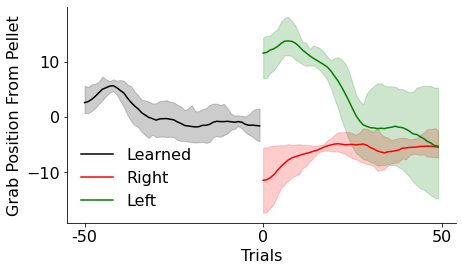

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\displacement_vs_trials\fig


In [4]:
df = pd.DataFrame(dd)
window_len = 9
epoch_0 = 50
epoch_1 = 50

fig = plt.figure(figsize=(9, 5))
rect = [0.25, 0.25, 0.6, 0.6]
ax = fig.add_axes(rect)

td = defaultdict(list)
temp = df.query("Epoch == 0")
epoch_0_success = np.array([x[-epoch_0:] for x in temp['Err']]).astype(float)
for i, x in enumerate(epoch_0_success):
    y = tools.smooth(x, window_len=window_len, window='flat')
    y = tools.smooth(y, window_len=5, window='flat')
    for j, yv in enumerate(y):
        td['x'].append(-len(y)+j)
        td['y'].append(yv)
sns.lineplot('x', 'y', data=td, ax=ax, color='black')

td = defaultdict(list)
temp = df.query("Epoch == 1")
epoch_1_success = np.array([x[:epoch_1] for x in temp['Err']]).astype(float)
for i, x in enumerate(epoch_1_success):
    y = tools.smooth(x, window_len=window_len, window='flat')
    y = tools.smooth(y, window_len=5, window='flat')
    for j, yv in enumerate(y):
        td['x'].append(j)
        td['y'].append(yv)
sns.lineplot('x', 'y', data=td, ax=ax, color='red')

td = defaultdict(list)
temp = df.query("Epoch == 2")
epoch_1_success = np.array([x[:epoch_1] for x in temp['Err']]).astype(float)
for i, x in enumerate(epoch_1_success):
    y = tools.smooth(x, window_len=window_len, window='flat')
    y = tools.smooth(y, window_len=5, window='flat')
    for j, yv in enumerate(y):
        td['x'].append(j)
        td['y'].append(yv)
        td['mouse'].append(i)
        td['epoch'].append(0)
sns.lineplot('x', 'y', data=td, ax=ax, color='green')

plt.xticks([-epoch_0, 0, epoch_1], [-epoch_0, 0, epoch_1])
plt.xlabel('Trials')
plt.ylabel('Grab Position From Pellet')
sns.despine()
plt.legend(['Learned', 'Right', 'Left'], frameon=False)

import plot_tools
plot_tools.save_fig(os.path.join(figure_path, 'displacement_vs_trials'), 'fig',
                    show=True)

In [88]:
from collections import defaultdict
dd = defaultdict(list)
for mouse, (dates, epochs) in mice_dict.items():
    data_good = []
    datay_good = []
    data_bad = []
    datay_bad = []
    for date in dates:
        analyzed_dir = os.path.join(r'C:\Users\Peter\Desktop\ANALYZED', mouse, date)
        csv = os.path.join(analyzed_dir, 'notes.csv')
        df = pd.read_csv(csv)
        mask = df['mask'].to_numpy() > 0

        label_regions_per_video, label_names = anz._get_labels(
            os.path.join(analyzed_dir, 'LABELS'))

        bps_to_include = np.unique([x for y in scheme for x in y])
        bp_dict = {bp: i for i, bp in enumerate(bps_to_include)}
        marker_xys_per_video = anz._get_markers(
            os.path.join(analyzed_dir, 'POSE_2D'),
            bps_to_include,
            base.CAMERA_NAMES)

        # grab locations
        x_grab_offset = 5
        y_grab_offset = -10
        grab_bps_ix = [bp_dict[bp] for bp in paw_location_markers]
        grabs = []
        trial_outcomes = []
        grab_outcomes = []
        for marker_xys, label_regions in zip(marker_xys_per_video,
                                             label_regions_per_video):
            grabs_per_trial = []
            for r in label_regions['grab']:
                scores = marker_xys[1][grab_bps_ix, :, 2]
                xp = marker_xys[0][grab_bps_ix, :, 0] + x_grab_offset
                yp = marker_xys[1][grab_bps_ix, :, 0] + y_grab_offset
                grab_x = anz._get_grab_locations_atomic(xp, scores, r)
                grab_y = anz._get_grab_locations_atomic(yp, scores, r)
                grabs_per_trial.append([grab_x, grab_y])
            grabs.append(grabs_per_trial)

            dropped_regions = label_regions['dropped']
            grabbed_regions = label_regions['grab']
            chew_regions = label_regions['chew']
            # chew region has to be greater than 50 consecutive
            chew_regions = [x for x in chew_regions if (x[1]-x[0]) > 50]
            # some insurance pellet drops at the start of trials, filter that out
            dropped_regions = [x for x in dropped_regions if x[0] > 30]
            outcome = anz.outcome_truth_table(dropped_regions,
                                              chew_regions,
                                              grabbed_regions)
            trial_outcomes.append(outcome)
            grab_outcome = anz.grab_truth_table(outcome,
                                                grabbed_regions,
                                                chew_regions,
                                                dropped_regions)
            grab_outcomes.append(grab_outcome)

        pellet_ix = bp_dict['pellet']
        xs = [marker_xys[0][pellet_ix, :, 0] for marker_xys in marker_xys_per_video]
        ys = [marker_xys[1][pellet_ix, :, 0] for marker_xys in marker_xys_per_video]
        ss = [marker_xys[0][pellet_ix, :, 2] for marker_xys in marker_xys_per_video]
        pellet_x = anz.get_pellet_location(xs, ss, plot=False)
        pellet_y = anz.get_pellet_location(ys, ss, plot=False)

        x_good = []
        x_bad = []
        y_good = []
        y_bad = []
        grabs_x = [[x[0] for x in gs] for gs in grabs]
        grabs_y = [[x[1] for x in gs] for gs in grabs]
        for m, gx, gy, outcomes, px, py in zip(mask,
                                              grabs_x,
                                               grabs_y,
                                              grab_outcomes,
                                              pellet_x,
                                              pellet_y):
            for gxx, gyy, outcome in zip(gx, gy, outcomes):
                if not m:
                    x_good.append(np.nan)
                    x_bad.append(np.nan)
                    y_good.append(np.nan)
                    y_bad.append(np.nan)
                else:
                    err = gxx - px
                    erry = gyy - py
                    if outcome == base.GRABTYPES.SNATCHED:
                        x_good.append(err)
                        x_bad.append(np.nan)
                        y_good.append(erry)
                        y_bad.append(np.nan)
                    else:
                        x_good.append(np.nan)
                        x_bad.append(err)
                        y_good.append(np.nan)
                        y_bad.append(erry)
        data_good.append(x_good)
        data_bad.append(x_bad)
        datay_good.append(y_good)
        datay_bad.append(y_bad)

    s = np.nan
    for i, epoch in enumerate(epochs):
        for gb, data, datay in zip(['Success', 'Fail'], [data_good, data_bad],
                                   [datay_good, datay_bad]):
            start_ix = dates.index(epoch[0])
            end_ix = dates.index(epoch[2])

            epoch_data = []
            epoch_data.append(data[start_ix][epoch[1]:])
            for j in range(start_ix+1, end_ix):
                epoch_data.append(data[j][:])
            epoch_data.append(data[end_ix][:epoch[3]])
            epoch_data = [x for y in epoch_data for x in y if not np.isnan(x)]

            epochy_data = []
            epochy_data.append(datay[start_ix][epoch[1]:])
            for j in range(start_ix+1, end_ix):
                epochy_data.append(datay[j][:])
            epochy_data.append(datay[end_ix][:epoch[3]])
            epochy_data = [x for y in epochy_data for x in y if not np.isnan(x)]

            dd['Mouse'].append(mouse)
            dd['Epoch'].append(i)
            dd['Err'].append(epoch_data)
            dd['ErrY'].append(epochy_data)
            dd['grabtype'].append(gb)
            l = len(epoch_data)
            if np.isnan(s):
                s = 0-l
            else:
                s = 0
            dd['Trials'].append(np.arange(s, s + l))
            s += l

more than 1 dropped region
more than 1 dropped region
more than 1 dropped region
more than 1 dropped region


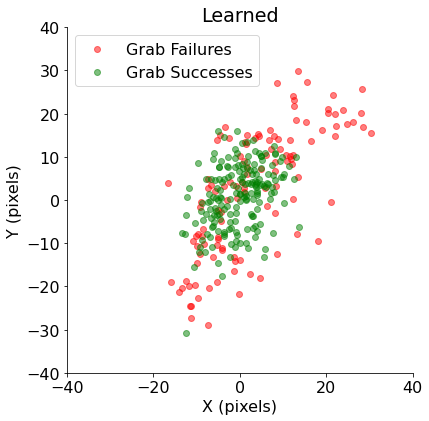

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\grabs_xyscatter\learned


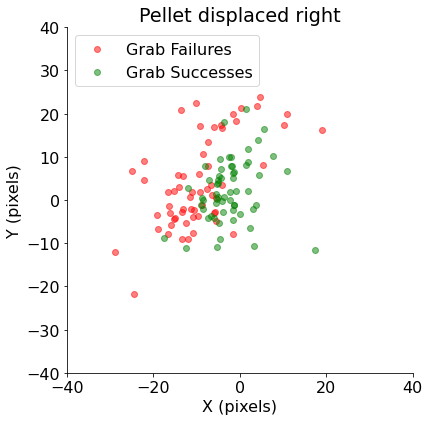

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\grabs_xyscatter\left


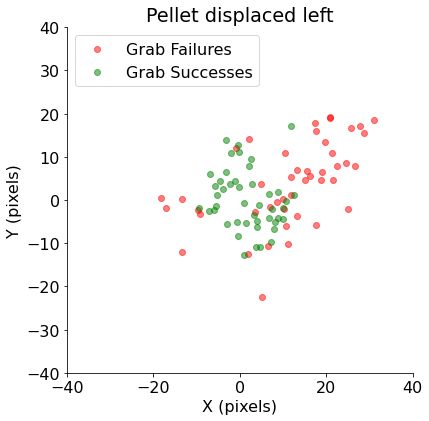

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\grabs_xyscatter\right


In [112]:
df = pd.DataFrame(dd)
first_n = 15

def _plot(epoch, first_n, title):
    temp = df.query(f'grabtype == "Success" & Epoch=={epoch}')
    errx = temp['Err'].to_list()
    errx = [y[:first_n] for y in errx]
    goodx = [x for y in errx for x in y]
    erry = temp['ErrY'].to_list()
    erry = [y[:first_n] for y in erry]
    goody = [x for y in erry for x in y]

    temp = df.query(f'grabtype == "Fail" & Epoch=={epoch}')
    errx = temp['Err'].to_list()
    errx = [y[:first_n] for y in errx]
    badx = [x for y in errx for x in y]
    erry = temp['ErrY'].to_list()
    erry = [y[:first_n] for y in erry]
    bady = [x for y in erry for x in y]

    fig = plt.figure(figsize=(8, 8))
    rect = [0.25, 0.25, 0.6, 0.6]
    ax = fig.add_axes(rect)
    ax.scatter(badx, bady, color='r', alpha=0.5, label='Grab Failures')
    ax.scatter(goodx, goody, color='g', alpha=0.5, label='Grab Successes')
    sns.despine()
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.xlim([-40, 40])
    plt.ylim([-40, 40])
    plt.title(f'{title}')
    plt.legend(loc='upper left')

p = os.path.join(figure_path, 'grabs_xyscatter')
_plot(epoch=0, first_n=50, title='Learned')
plot_tools.save_fig(p, 'learned', show=True)

_plot(epoch=1, first_n=first_n, title='Pellet displaced right')
plot_tools.save_fig(p, 'left', show=True)

_plot(epoch=2, first_n=first_n, title='Pellet displaced left')
plot_tools.save_fig(p, 'right', show=True)


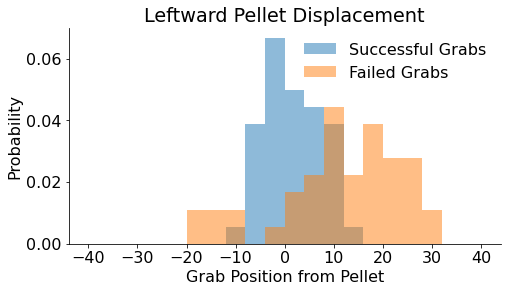

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\success_vs_failed_grabs\left


In [6]:
import plot_tools
first_n = 15
bins = 20
xrange = [-40, 40]

df = pd.DataFrame(dd)
temp = df.query('grabtype == "Success" & Epoch==2')
err = temp['Err'].to_list()
err = [y[:first_n] for y in err]
good = [x for y in err for x in y]

temp = df.query('grabtype == "Fail" & Epoch==2')
err = temp['Err'].to_list()
err = [y[:first_n] for y in err]
bad = [x for y in err for x in y]


fig = plt.figure(figsize=(10, 5))
rect = [0.25, 0.25, 0.6, 0.6]
ax = fig.add_axes(rect)
plt.hist(good, alpha=0.5, bins=bins, range=xrange, density=True)
plt.hist(bad, alpha=0.5, bins=bins, range=xrange, density=True)
plt.title('Leftward Pellet Displacement')
plt.xlabel('Grab Position from Pellet')
plt.ylabel('Probability')
plt.legend(['Successful Grabs', 'Failed Grabs'], frameon=False)
sns.despine()

plot_tools.save_fig(os.path.join(figure_path,
                                 'success_vs_failed_grabs'),
                    'left',
                    show=True)

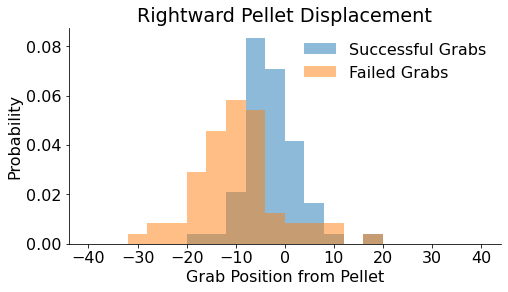

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\success_vs_failed_grabs\right


In [7]:
first_n = 15
bins = 20
range = [-40, 40]

df = pd.DataFrame(dd)
temp = df.query('grabtype == "Success" & Epoch==1')
err = temp['Err'].to_list()
err = [y[:first_n] for y in err]
good = [x for y in err for x in y]

temp = df.query('grabtype == "Fail" & Epoch==1')
err = temp['Err'].to_list()
err = [y[:first_n] for y in err]
bad = [x for y in err for x in y]


fig = plt.figure(figsize=(10, 5))
rect = [0.25, 0.25, 0.6, 0.6]
ax = fig.add_axes(rect)
plt.hist(good, alpha=0.5, bins=bins, range=range, density=True)
plt.hist(bad, alpha=0.5, bins=bins, range=range, density=True)
plt.title('Rightward Pellet Displacement')
plt.xlabel('Grab Position from Pellet')
plt.ylabel('Probability')
plt.legend(['Successful Grabs', 'Failed Grabs'], frameon=False)
sns.despine()

plot_tools.save_fig(os.path.join(figure_path,
                                 'success_vs_failed_grabs'),
                    'right',
                    show=True)

